# WAMM fire analysis case study <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [9]:
# import numpy as np
# import requests
# import pandas as pd

# from shapely.geometry import shape
# from pandas.io.json import json_normalize
# import matplotlib.pyplot as plt

import sys
import datacube
import geopandas as gpd
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices

## Analysis

In [2]:
dc = datacube.Datacube(app="Sentinel_2")

In [3]:
# Create a query object
query = {
    "x": (147.869445, 148.065825),
    "y": (-42.025447, -42.164544),
    "measurements": ["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_swir_2", "nbart_swir_3"],
    "output_crs": "EPSG:32755",
    "resolution": (-10, 10),
    "group_by": "solar_day",
    "resampling": {'*': 'average', 'fmask': 'nearest'},
    "dask_chunks": {}
}


ds = load_ard(dc=dc,
              products=["s2a_nrt_granule", "s2b_nrt_granule"],
              **query)

Loading s2a_nrt_granule data
    Applying pixel quality mask
Loading s2b_nrt_granule data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 


In [4]:
ds = calculate_indices(ds, index='MNDWI', 
                       custom_varname='water_index', 
                       collection='ga_s2_1', 
                       drop=False)

In [5]:
# Apply 0 MNDWI threshold and make sure nodata pixels are preserved 
# (otherwise '>' operation nodata will set nodata to False)
ds_thresholded = (ds.water_index > 0).where(~ds.water_index.isnull())

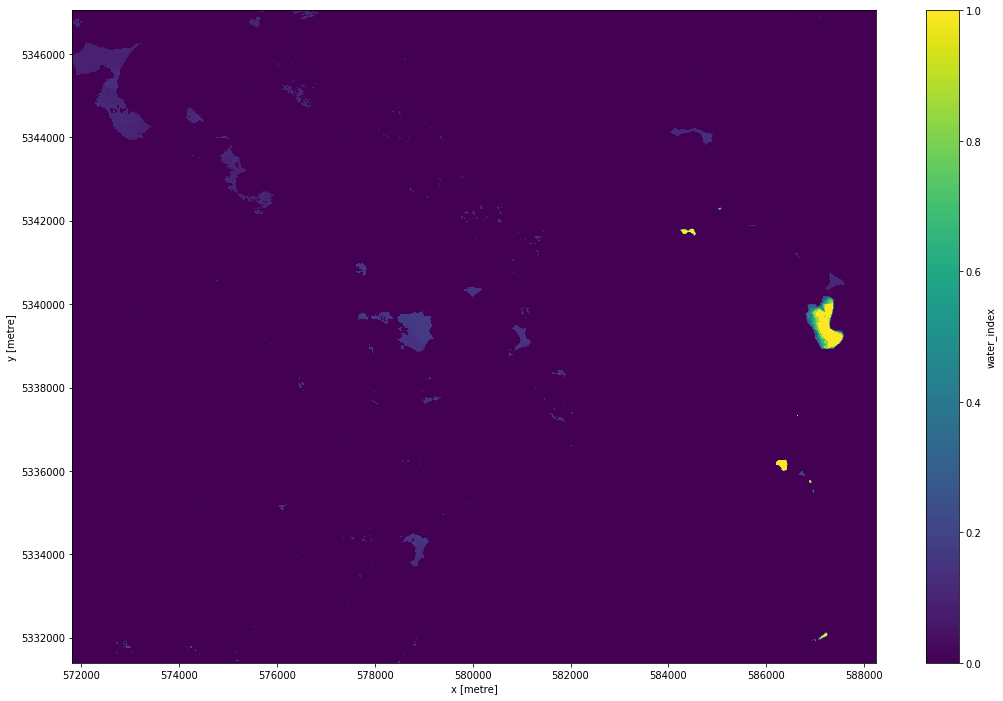

In [6]:
# Plot mean of threshholded layer to get percentage observed as wet 
# (accounting for nodata)
ds_thresholded.mean(dim='time').plot(size=12)

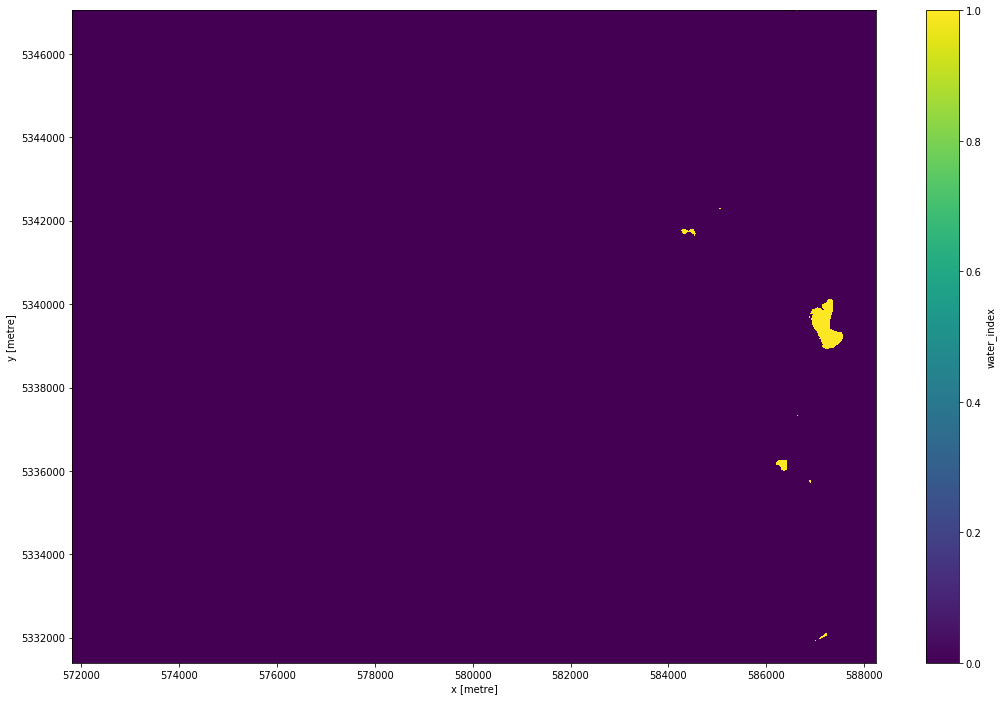

In [7]:
# Threshold to wet 50% of the three month NRT period to get a boolean layer
(ds_thresholded.mean(dim='time') > 0.5).plot(size=12)

## Export to shapefile

In [10]:
import rasterio.features
import shapely.geometry

# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform

# Run the vectorizing function
vectors = rasterio.features.shapes(source=(ds_thresholded.mean(dim='time') > 0.5).data.astype('int16'),
                                   mask=(ds_thresholded.mean(dim='time') > 0.5).data,
                                   transform=transform)
# First convert the genertor into a list, as a generator can only be consumed once
vectors = list(vectors)

# # Extract the polygon coordinates and values from the list using list comprehension
polygons = [polygon for polygon, value in vectors]
values = [value for polygon, value in vectors]

print('Image value: ' + str(values[0]))
print('Geometry:')
# pprint.pprint(polygons[0])


# First we need to convert our polygon coordinates into polygon shapes
polygons = [shapely.geometry.shape(polygon) for polygon in polygons]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'attributes': values},
                       geometry=polygons,
                       crs=str(ds.crs))

Image value: 1.0
Geometry:


In [12]:
# Export to geojson
gdf.crs = {'init': "EPSG:32755"}
gdf.to_crs({'init': 'EPSG:4326'}).to_file(filename='tasmania_waterbodies.geojson', driver='GeoJSON')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)